In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.metrics import R2Score
from sklearn.preprocessing import MinMaxScaler

from src import *

/root/cryptobot-enviroment/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2025-01-02 22:55:55.270670: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 22:55:55.278262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 22:55:55.295833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735869355.319948   27624 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plu

In [2]:
# Fetch Ripple price data
df = read_yfinance_crypto_data("ATA-USD", "max", "1d")
scaler = MinMaxScaler()

[
    [train_date_series, train_data, normalized_data],
    [test_date_series, testData, normalized_test_data]
] = pre_process_data(df, scaler)

print(f"Train Data: {train_data.shape}\nTest Data: {testData.shape}")

test_target = testData
print(f"Train Target: {train_data.shape}\nTest Data: {test_target.shape}")

Cutoff:  391
Train Data: (915, 1)
Test Data: (391, 1)
Train Target: (915, 1)
Test Data: (391, 1)


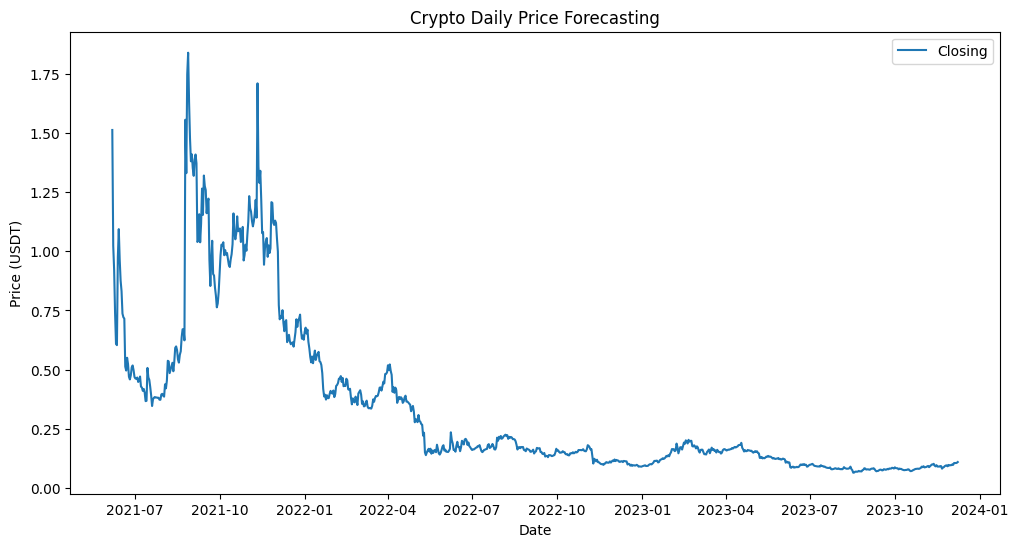

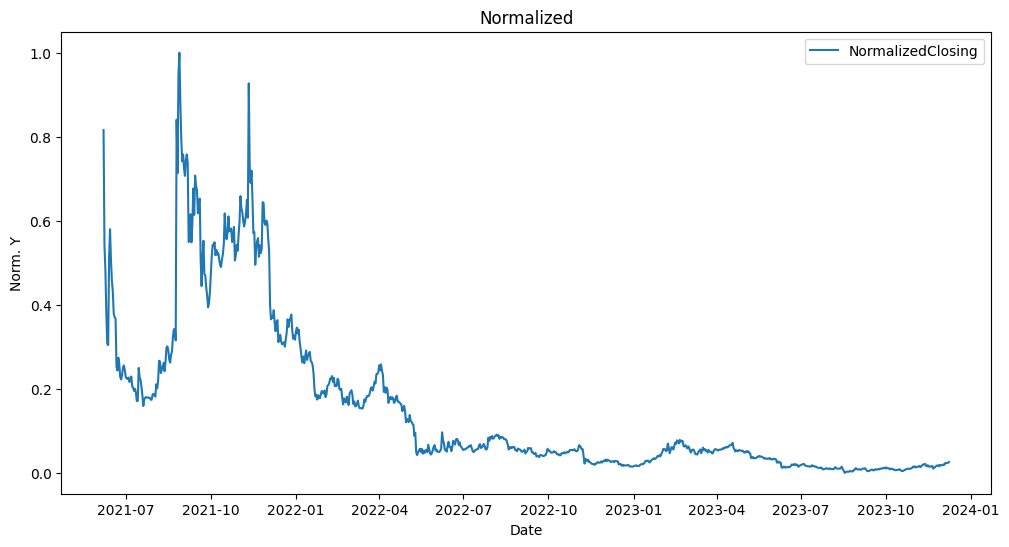

In [3]:
# Plot train data
plt.figure(figsize=(12, 6))
plt.plot(train_date_series, train_data, label='Closing')
plt.title('Crypto Daily Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(train_date_series, normalized_data, label='NormalizedClosing')
plt.title('Normalized')
plt.xlabel('Date')
plt.ylabel('Norm. Y')
plt.legend()
plt.show()

In [4]:
# Prepare data for each EWT component
seq_len = 90
X, y, train_data, train_date_series = prepare_data(
    normalized_data,
    train_data,
    train_date_series,
    seq_len
)

print(y.shape, X.shape, train_date_series.shape, train_data.shape)

(825, 1) (825, 90, 1) (825,) (825, 1)


In [5]:
# Create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(input_shape),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [6]:
# Train separate LSTM models for each EWT component
model = create_lstm_model((seq_len, 1))
model.fit(X, y, epochs=100, verbose=2 )


Epoch 1/100


2025-01-02 22:56:35.954859: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


26/26 - 6s - 218ms/step - loss: 0.0321
Epoch 2/100
26/26 - 2s - 89ms/step - loss: 0.0051
Epoch 3/100
26/26 - 2s - 84ms/step - loss: 0.0052
Epoch 4/100
26/26 - 2s - 86ms/step - loss: 0.0043
Epoch 5/100
26/26 - 2s - 83ms/step - loss: 0.0041
Epoch 6/100
26/26 - 2s - 87ms/step - loss: 0.0040
Epoch 7/100
26/26 - 2s - 83ms/step - loss: 0.0042
Epoch 8/100
26/26 - 2s - 84ms/step - loss: 0.0037
Epoch 9/100
26/26 - 2s - 85ms/step - loss: 0.0036
Epoch 10/100
26/26 - 2s - 85ms/step - loss: 0.0038
Epoch 11/100
26/26 - 2s - 87ms/step - loss: 0.0043
Epoch 12/100
26/26 - 2s - 82ms/step - loss: 0.0036
Epoch 13/100
26/26 - 2s - 85ms/step - loss: 0.0035
Epoch 14/100
26/26 - 2s - 82ms/step - loss: 0.0037
Epoch 15/100
26/26 - 2s - 85ms/step - loss: 0.0029
Epoch 16/100
26/26 - 2s - 82ms/step - loss: 0.0036
Epoch 17/100
26/26 - 2s - 85ms/step - loss: 0.0036
Epoch 18/100
26/26 - 2s - 84ms/step - loss: 0.0032
Epoch 19/100
26/26 - 2s - 82ms/step - loss: 0.0034
Epoch 20/100
26/26 - 2s - 84ms/step - loss: 0.0031


In [15]:
# Make predictions
predictions = np.zeros_like(y)
for i in range(seq_len, len(y)):
    inputs = normalized_data[i-seq_len:i]
    pred = model.predict(inputs.reshape(1, seq_len, 1 ), verbose=1)
    # Reshape the prediction to match the original data shape
    predictions[i] = pred

reshaped = predictions.reshape(-1, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━

(1739, 1) (1739,) (1739, 1)


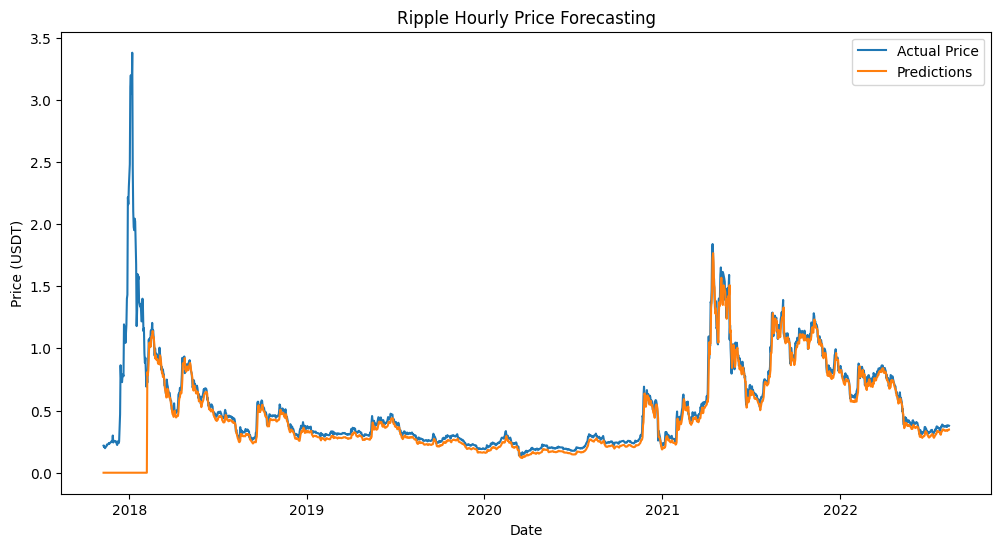

In [17]:
print(train_data.shape, train_date_series.shape, reshaped.shape)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(train_date_series, train_data, label='Actual Price')
plt.plot(train_date_series, reshaped, label='Predictions')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()


In [18]:
# Evaluate the model
mse = np.mean((train_data[seq_len:] - reshaped[seq_len:]) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(train_data[seq_len:] - reshaped[seq_len:]))
mape = np.mean(np.abs((train_data[seq_len:] - reshaped[seq_len:]) / train_data[seq_len:])) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 0.0512
MAE: 0.0391
MAPE: 9.3631


In [7]:
normalized_test_data = scaler.transform(testData)
X_test, y_test, testData, test_date_series = prepare_data(normalized_test_data, testData, test_date_series, seq_len)
y_test = y_test.reshape(-1, 1)
y_test.shape
print(testData.shape)

(301, 1)


In [8]:
model.evaluate(X_test, y_test, verbose=2)

10/10 - 1s - 82ms/step - loss: 2.3750e-04


0.00023749962565489113

In [9]:
# Make test predictions
test_predictions = np.zeros_like(y_test)
for i in range(seq_len, len(y_test)):
    print(i)
    inputs = normalized_test_data[i-seq_len:i]
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    test_predictions[i] = pred

90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
(1, 1)
91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(1, 1)
92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
(1, 1)
93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
(1, 1)
94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
(1, 1)
95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 1)
96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
(1, 1)
97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 1)
98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(1, 1)
99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
(1, 1)
100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
(1, 1)
101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(1, 1)
102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
(1, 1)
103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
(1, 1)
104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 1)
105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 1)
106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 1)
107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
(1, 1)
108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(1, 1)
109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(1, 1)
110
1/1 ━━━━━━━━━━━━━━━━━━━━

(301,) (301, 1) (301, 1)


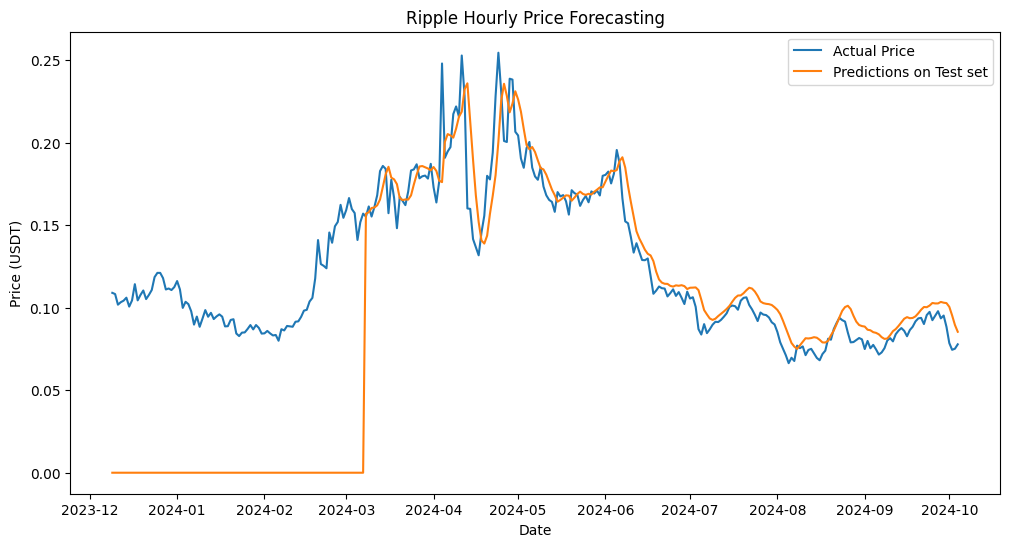

In [10]:
test_reshaped = test_predictions.reshape(-1, 1)
print(test_date_series.shape, testData.shape, test_reshaped.shape)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(test_date_series[:], testData[:], label='Actual Price')
plt.plot(test_date_series[:], test_reshaped[:], label='Predictions on Test set')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

In [11]:
# Evaluate the model 
r2 = R2Score()
testDataToUse = testData[seq_len:]
testPredictionsToUse = test_reshaped[seq_len:]
print(testDataToUse.shape, testPredictionsToUse.shape)

r2.update_state(testDataToUse, testPredictionsToUse)
r2.result().numpy()

mse = np.mean((testDataToUse - testPredictionsToUse) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(testDataToUse - testPredictionsToUse))
mape = np.mean(np.abs((testDataToUse - testPredictionsToUse) / testDataToUse)) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"accuracy: {r2.result().numpy()}")

(211, 1) (211, 1)
RMSE: 0.0155
MAE: 0.0107
MAPE: 8.6296
accuracy: 0.8973293900489807


In [12]:
!mkdir -p saved_models
model.save("saved_models/ata-p90-1f-2L.keras")